In [0]:
# Must Run 
# %pip install google-cloud-bigquery


In [0]:
# key_json key_bq.json shared separately by email, easier to copy the key content here

## Fetch Data from BigQuery

In [0]:
from google.cloud import bigquery
from google.oauth2 import service_account
import json
import pandas as pd

# Kimlik doğrulama
credentials = service_account.Credentials.from_service_account_info(
    key_json, scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# BigQuery istemcisini oluştur
client = bigquery.Client(credentials=credentials, project=key_json["project_id"])

# query = "SELECT * FROM `pemo-assessment-462223.pemo.transaction` LIMIT 10"

query_1_1 = """
with 
a as 
(
select company_id as company_id, category, sum(billed_amount_aed) as total_amount_aed, count(1) number_of_trx 
from pemo-assessment-462223.pemo.transaction group by 1,2 order by 1,3 desc
),
b as 
(
select *, row_number () over (partition by company_id order by total_amount_aed desc) rn from a order by 1,3,2
)
select company_id, category as most_spending_category, total_amount_aed from b where rn = 1 
"""

query_1_2 ="""
select date_trunc(transaction_date,month) as year_month, count(1) cnt, sum(billed_amount_aed) total_amount_aed
from pemo-assessment-462223.pemo.transaction group by 1 order by 1
"""

query_1_3 ="""
with 
company_profile as 
(
select company_id, count(1) cnt, sum(billed_amount_aed) total_amount_aed, avg(billed_amount_aed) avg_amount_aed 
from pemo-assessment-462223.pemo.transaction 
group by 1 order by 1
),
billed_delta as 
(
select t.*, cp.avg_amount_aed, cp.avg_amount_aed - billed_amount_aed as delta from pemo-assessment-462223.pemo.transaction t join company_profile cp on t.company_id = cp.company_id where t.company_id is not null
)
select company_id, count(1) cnt,
sum(billed_amount_aed) billed_amount_aed,
avg(avg_amount_aed) avg_amount_aed
from billed_delta where abs(delta) >= 2 * avg_amount_aed
group by 1

-- select 
-- case 

--   when abs(delta) / avg_amount_aed >= 2 and abs(delta) / avg_amount_aed < 3 then '2-3' 
--   when abs(delta) / avg_amount_aed >= 3 and abs(delta) / avg_amount_aed < 4 then '3-4'
--   when abs(delta) / avg_amount_aed >= 4 and abs(delta) / avg_amount_aed < 5 then '4-5'
--   when abs(delta) / avg_amount_aed >= 5 and abs(delta) / avg_amount_aed < 6 then '5-6'
--   else '6+'
-- end as delta_over_avg, 
-- count(1) cnt,
-- sum(billed_amount_aed) billed_amount_aed,
-- avg(avg_amount_aed) avg_amount_aed
-- -- count(1) 
-- from billed_delta where abs(delta) >= 2 * avg_amount_aed
-- group by 1


"""

query_2_1 ="""
with 
a as 
(
select  company_id, 
        sum(case when currency != 'AED' then 0 else 1 end) as number_of_local_trx,
        sum(case when currency != 'AED' then 0 else billed_amount_aed end) as aed_amount_of_local_trx,
        sum(case when currency != 'AED' then 1 else 0 end) as number_of_foreign_trx,
        sum(case when currency != 'AED' then billed_amount_aed else 0 end) as aed_amount_of_foreign_trx
        -- count(1) cnt, sum(billed_amount_aed) billed_amount_aed 
from    pemo-assessment-462223.pemo.transaction
-- where currency != 'AED'
group by 1 
),
b as 
(
select  
case 
  when number_of_local_trx = 0 and number_of_foreign_trx > 100 then 'Super Risky | More than 100 transactions are foreign, no local transactions' 
  when number_of_local_trx >= 0 and number_of_local_trx < 10 and number_of_foreign_trx > 100 then 'Risky | More than 100 transactions are foreign, 0-10 local transactions' 
  when number_of_foreign_trx > 0 then 'Less Risky | At least 1 transaction in foreign exchange' 
else 'L' end as class, * from a
)
-- select count(1) cnt from a
select class, count(1) cnt from b group by 1
"""

query_2_2 ="""
with 
merchant_profile as 
(
select merchant, count(1) cnt, count(distinct user_id) number_of_users from pemo-assessment-462223.pemo.transaction group by 1
),
mp_2 as
(select merchant, cnt/number_of_users as avg_trx_per_user from merchant_profile),
user_merchant as 
(
select user_id, merchant, count(1) cnt from pemo-assessment-462223.pemo.transaction group by 1,2
),
a as 
(
select user_id, coalesce(a.merchant,b.merchant) merchant, avg_trx_per_user, cnt from user_merchant a left join mp_2 b on a.merchant = b.merchant
),
b as 
(
select case when cnt / avg_trx_per_user <  1.0 then 'OK | <1.0'
            when cnt / avg_trx_per_user >= 1.0 and cnt / avg_trx_per_user < 1.5 then 'OK | >=1.0-1.5'
            when cnt / avg_trx_per_user >= 1.5 and cnt / avg_trx_per_user < 2.0 then 'OKish | >=1.5-2.0'
            when cnt / avg_trx_per_user >= 2.0 and cnt / avg_trx_per_user < 2.5 then 'NOK | >=2.0-2.5' 
            when cnt / avg_trx_per_user >= 2.5 then 'NOK | >=2.5' 
            else null end 
            as compare, cnt / avg_trx_per_user as value,
            * from a
) 
-- select compare, count(1) cnt from b group by 1
select * from b where compare like 'NOK%' order by value desc 
"""

query_2_3 ="""
with 
percentiles as 
(
  select 
    approx_quantiles(billed_amount_aed, 100)[offset(25)] AS q1,
    approx_quantiles(billed_amount_aed, 100)[offset(75)] AS q3
  from  pemo-assessment-462223.pemo.transaction
),
limits as 
(
select  
      t.*,
      p.q1,
      p.q3,
      (p.q3 - p.q1) * 3           as iqr_range,
      p.q3 + (p.q3 - p.q1) * 3    as upper_limit
from  pemo-assessment-462223.pemo.transaction t
cross join percentiles p
)
select    *
from      limits
where     billed_amount_aed > upper_limit
order by  billed_amount_aed desc
"""

query_3_1 ="""
with 
-- max total transaction amount company
a as    
(select company_id, status, sum(billed_amount_aed) as total_amount_aed from pemo-assessment-462223.pemo.transaction group by 1,2 order by 1,2 desc),
b as 
(select * from a where status = 'APPROVED' order by 3 desc),
c as 
(select company_id, total_amount_aed from b order by 2 desc limit 20),
-- select company_id, count(1) cnt from b group by 1 having count(1) >1 
d as 

(
-- Most frequetly used category amounts
select company_id, sum(billed_amount_aed) total_amount_aed 
from pemo-assessment-462223.pemo.transaction where status = 'APPROVED' and category in 
(select category from (select category, sum(billed_amount_aed) total_amount_aed from pemo-assessment-462223.pemo.transaction where status = 'APPROVED' group by 1 order by 2 desc limit 1))
group by 1 order by 2 desc limit 20
),
e as 
(
select * from c union all
select * from d
)
select distinct company_id from e
"""

query_3_2 ="""
select      category, merchant, sum(billed_amount_aed) AS total_amount_aed, count(1) as cnt
from        pemo-assessment-462223.pemo.transaction
group by    category, merchant
order by    3 desc
limit 40
"""

# Execute Query and to DF
query_job_1_1 = client.query(query_1_1)
results_1_1 = query_job_1_1.result()
data_1_1 = [dict(row) for row in results_1_1]
df_1_1 = pd.DataFrame(data_1_1)
display(df_1_1.head())

query_job_1_2 = client.query(query_1_2)
results_1_2 = query_job_1_2.result()
data_1_2 = [dict(row) for row in results_1_2]
df_1_2 = pd.DataFrame(data_1_2)
display(df_1_2.head())

query_job_1_3 = client.query(query_1_3)
results_1_3 = query_job_1_3.result()
data_1_3 = [dict(row) for row in results_1_3]
df_1_3 = pd.DataFrame(data_1_3)
display(df_1_3.head())

query_job_2_1 = client.query(query_2_1)
results_2_1 = query_job_2_1.result()
data_2_1 = [dict(row) for row in results_2_1]
df_2_1 = pd.DataFrame(data_2_1)
display(df_2_1.head())

query_job_2_2 = client.query(query_2_2)
results_2_2 = query_job_2_2.result()
data_2_2 = [dict(row) for row in results_2_2]
df_2_2 = pd.DataFrame(data_2_2)
display(df_2_2.head())

query_job_2_3 = client.query(query_2_3)
results_2_3 = query_job_2_3.result()
data_2_3 = [dict(row) for row in results_2_3]
df_2_3 = pd.DataFrame(data_2_3)
display(df_2_3.head())

query_job_3_1 = client.query(query_3_1)
results_3_1 = query_job_3_1.result()
data_3_1 = [dict(row) for row in results_3_1]
df_3_1 = pd.DataFrame(data_3_1)
display(df_3_1.head())

query_job_3_2 = client.query(query_3_2)
results_3_2 = query_job_3_2.result()
data_3_2 = [dict(row) for row in results_3_2]
df_3_2 = pd.DataFrame(data_3_2)
display(df_3_2.head())


company_id,most_spending_category,total_amount_aed
CMP001,SaaS,2785872.5500000003
CMP002,SaaS,2837546.62
CMP003,SaaS,1981343.1400000008
CMP004,SaaS,1879495.8699999999
CMP005,Advertisement,1886159.5299999996


year_month,cnt,total_amount_aed
2024-01-01,2117,1.2382313540000007E7
2024-02-01,2106,1.0441782530000018E7
2024-03-01,2031,1.1460764110000014E7
2024-04-01,2079,1.1620232799999982E7
2024-05-01,2121,1.2363859760000004E7


company_id,cnt,billed_amount_aed,avg_amount_aed
CMP010,46,1772084.7900000003,5129.8716181229765
CMP013,85,1671764.4599999997,4396.584778761066
CMP007,35,2037551.29,5177.941345177659
CMP002,20,1570834.5300000005,6027.990015503872
CMP014,69,1574921.04,4656.684212999215


class,cnt
Less Risky | At least 1 transaction in foreign exchange,15
"Super Risky | More than 100 transactions are foreign, no local transactions",5


compare,value,user_id,merchant,avg_trx_per_user,cnt
NOK | >=2.5,2.940594059405941,USR0078,Air Arabia,4.08080808080808,12
NOK | >=2.5,2.5882352941176467,USR0028,Amazon,4.636363636363637,12
NOK | >=2.5,2.582608695652174,USR0048,Retool,5.808080808080808,15
NOK | >=2.5,2.577006507592191,USR0039,Waitrose,4.656565656565657,12
NOK | >=2.5,2.577006507592191,USR0043,Waitrose,4.656565656565657,12


transaction_id,company_id,user_id,transaction_date,merchant,category,amount,currency,billed_amount_AED,status,q1,q3,iqr_range,upper_limit
TXN13449,CMP019,USR0088,2024-12-31,Microsoft*Xbox,Entertainment,86441.61600000001,USD,317240.73,PENDING,1612.97,6988.31,16126.02,23114.33
TXN03083,CMP002,USR0016,2024-12-31,GooglePlay,SaaS,80026.434,USD,293697.01,APPROVED,1612.97,6988.31,16126.02,23114.33
TXN13698,CMP005,USR0025,2024-12-31,Facebook,SaaS,79105.03199999999,USD,290315.47,DECLINED,1612.97,6988.31,16126.02,23114.33
TXN02758,CMP005,USR0081,2024-08-31,Microsoft*Xbox,Advertisement,76922.368,USD,282305.09,APPROVED,1612.97,6988.31,16126.02,23114.33
TXN13905,CMP015,USR0015,2024-12-31,GooglePlay,Entertainment,76277.214,USD,279937.38,DECLINED,1612.97,6988.31,16126.02,23114.33


company_id
CMP016
CMP020
CMP017
CMP018
CMP002


category,merchant,total_amount_aed,cnt
Advertisement,Tiktok,8468296.72,1594
Advertisement,LinkedIn,8201682.779999994,1547
Advertisement,GoogleAds,8008076.360000008,1516
Advertisement,Meta,7987815.009999994,1510
Retail,GooglePlay,3454195.8199999994,478


## Summary Report with Insights

Summary Report with Insights
Question 1.1: What are the top spending categories across companies?
Answer 1.1: By finding the top spending category for each company, amount distribution for top spending category is as follows


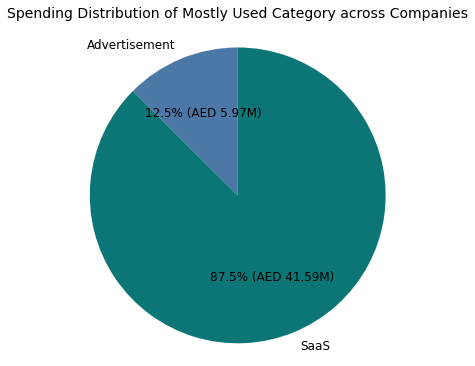

Question 1.2. Are there seasonal trends in spending?
Answer 1.2. There is significant increase in number of transactions on 2024-05 and 2024-10 and similarly for the spending amount 2024-07 and 2024-12, but on the other hand, there seems like there is no positive correlation between the number of transactions and total spending amount.


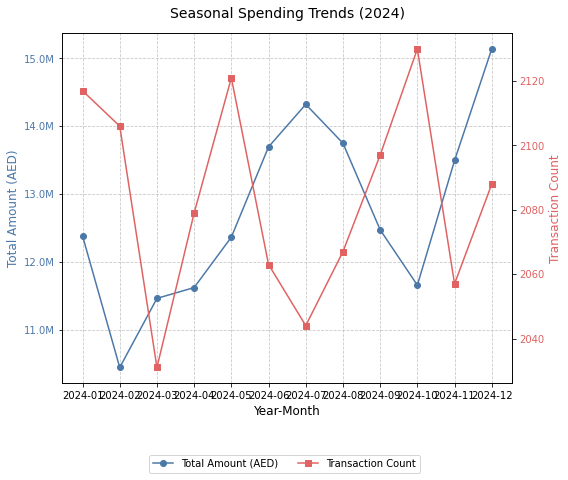

Question 1.3: Which companies have unusually high spending?
Answer 1.3: By profiling the companies as per their average transation count or amount, we can find a way to assess whether there is an unusual pattern is being recorded, below you can find the top 5 highest unusual spending.


company_id,cnt,billed_amount_aed,avg_amount_aed
CMP010,46,1772084.7900000003,5129.8716181229765
CMP013,85,1671764.4599999997,4396.584778761066
CMP007,35,2037551.29,5177.941345177659
CMP002,20,1570834.5300000005,6027.990015503872
CMP014,69,1574921.04,4656.684212999215


Question 2.1: Identify companies where a large percentage of transactions are in a foreign currency—could this indicate international misuse?
Answer 2.1: What is suspicious is not all the foreign currency transactions, it is suspicious if user never made local trassaction bu made only foreign transactions


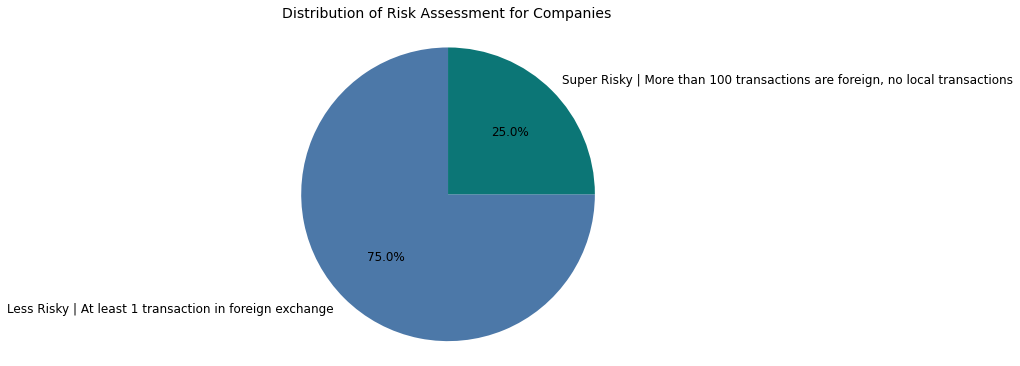

Question 2.2. Are there users transacting at a high rate with a single merchant?
Answer 2.2: Again, by creating profile for a user by checkign the previous trasnactions, hikes can be easily identified.


compare,value,user_id,merchant,avg_trx_per_user,cnt
NOK | >=2.5,2.940594059405941,USR0078,Air Arabia,4.08080808080808,12
NOK | >=2.5,2.5882352941176467,USR0028,Amazon,4.636363636363637,12
NOK | >=2.5,2.582608695652174,USR0048,Retool,5.808080808080808,15
NOK | >=2.5,2.577006507592191,USR0039,Waitrose,4.656565656565657,12
NOK | >=2.5,2.577006507592191,USR0043,Waitrose,4.656565656565657,12


Question 2.3. Identify outlier transactions (e.g., transactions that are significantly larger than the norm) that are greater than 3x the interquartile range (IQR) from the median transaction value.
Answer 2.3: by using statistical calculations (approx_quantiles) some limits are being calculated, and according to this limit we identified the outlier.


transaction_id,company_id,user_id,transaction_date,merchant,category,amount,currency,billed_amount_AED,status,q1,q3,iqr_range,upper_limit
TXN13449,CMP019,USR0088,2024-12-31,Microsoft*Xbox,Entertainment,86441.61600000001,USD,317240.73,PENDING,1612.97,6988.31,16126.02,23114.33
TXN03083,CMP002,USR0016,2024-12-31,GooglePlay,SaaS,80026.434,USD,293697.01,APPROVED,1612.97,6988.31,16126.02,23114.33
TXN13698,CMP005,USR0025,2024-12-31,Facebook,SaaS,79105.03199999999,USD,290315.47,DECLINED,1612.97,6988.31,16126.02,23114.33
TXN02758,CMP005,USR0081,2024-08-31,Microsoft*Xbox,Advertisement,76922.368,USD,282305.09,APPROVED,1612.97,6988.31,16126.02,23114.33
TXN13905,CMP015,USR0015,2024-12-31,GooglePlay,Entertainment,76277.214,USD,279937.38,DECLINED,1612.97,6988.31,16126.02,23114.33


Question 3.1. Based on spending patterns, which companies or industries could be ideal for upselling new financial products?
Answer 3.1: There is no direct correlation between the merchant/categories and financial products. Thats why, the companies which have spent the maximum amount and SaaS used companies can be ideal, as they are very keen on spending.


company_id
CMP016
CMP020
CMP017
CMP018
CMP002


Question 3.2. If Pemo were to offer discounts or rewards, which categories/merchants would be the best to target?
Answer 3.2: Similarly, we have tracked the most spending merchant ant category transactions.


category,merchant,total_amount_aed,cnt
Advertisement,Tiktok,8468296.72,1594
Advertisement,LinkedIn,8201682.779999994,1547
Advertisement,GoogleAds,8008076.360000008,1516
Advertisement,Meta,7987815.009999994,1510
Retail,GooglePlay,3454195.8199999994,478


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# display(df_1_1.head())

print('Summary Report with Insights')

print('Question 1.1: What are the top spending categories across companies?')

print('Answer 1.1: By finding the top spending category for each company, amount distribution for top spending category is as follows')

# Aggregate total_amount_aed by most_spending_category
category_totals = df_1_1.groupby('most_spending_category')['total_amount_aed'].sum().reset_index()

# Function to format labels with amount and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}% (AED {val / 1e6:.2f}M)'
    return my_autopct

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    category_totals['total_amount_aed'],
    labels=category_totals['most_spending_category'],
    autopct=make_autopct(category_totals['total_amount_aed']),
    colors=['#4c78a8','#0c7676'],
    startangle=90,
    textprops={'fontsize': 12}
)
plt.title('Spending Distribution of Mostly Used Category across Companies', fontsize=14, pad=15)
plt.axis('equal')  # Equal aspect ratio ensures pie is circular

# Save and show the plot
plt.savefig('category_spending_pie_chart.png')
plt.show()


print('Question 1.2. Are there seasonal trends in spending?')
print('Answer 1.2. There is significant increase in number of transactions on 2024-05 and 2024-10 and similarly for the spending amount 2024-07 and 2024-12, but on the other hand, there seems like there is no positive correlation between the number of transactions and total spending amount.')

df_1_2['year_month'] = pd.to_datetime(df_1_2['year_month']).dt.strftime('%Y-%m')

# Function to format y-axis in millions
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

# Create line chart
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot total_amount_aed
ax1.plot(df_1_2['year_month'], df_1_2['total_amount_aed'], marker='o', color='#4c78a8', label='Total Amount (AED)')
ax1.set_xlabel('Year-Month', fontsize=12)
ax1.set_ylabel('Total Amount (AED)', fontsize=12, color='#4c78a8')
ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax1.tick_params(axis='y', labelcolor='#4c78a8')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create secondary y-axis for cnt
ax2 = ax1.twinx()
ax2.plot(df_1_2['year_month'], df_1_2['cnt'], marker='s', color='#e06262', label='Transaction Count')
ax2.set_ylabel('Transaction Count', fontsize=12, color='#e06262')
ax2.tick_params(axis='y', labelcolor='#e06262')

# Title and legend
plt.title('Seasonal Spending Trends (2024)', fontsize=14, pad=15)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()

# Save and show the plot
plt.savefig('seasonality_line_chart.png')
plt.show()
# ax.text(1,1,"my text", ha="right")

print('Question 1.3: Which companies have unusually high spending?')
print('Answer 1.3: By profiling the companies as per their average transation count or amount, we can find a way to assess whether there is an unusual pattern is being recorded, below you can find the top 5 highest unusual spending.')

display(df_1_3.head())

print('Question 2.1: Identify companies where a large percentage of transactions are in a foreign currency—could this indicate international misuse?')
print('Answer 2.1: What is suspicious is not all the foreign currency transactions, it is suspicious if user never made local trassaction bu made only foreign transactions')

# Aggregate total_amount_aed by most_spending_category
category_totals = df_2_1.groupby('class')['cnt'].sum().reset_index()

# Function to format labels with amount and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%' # (AED {val / 1e6:.2f}M)'
    return my_autopct

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    category_totals['cnt'],
    labels=category_totals['class'],
    autopct=make_autopct(category_totals['cnt']),
    colors=['#4c78a8','#0c7676'],
    startangle=90,
    textprops={'fontsize': 12}
)
plt.title('Distribution of Risk Assessment for Companies', fontsize=14, pad=15)
plt.axis('equal')  # Equal aspect ratio ensures pie is circular

# Save and show the plot
plt.savefig('category_spending_pie_chart.png')
plt.show()

print('Question 2.2. Are there users transacting at a high rate with a single merchant?')
print('Answer 2.2: Again, by creating profile for a user by checkign the previous trasnactions, hikes can be easily identified.')

display(df_2_2.head())

print('Question 2.3. Identify outlier transactions (e.g., transactions that are significantly larger than the norm) that are greater than 3x the interquartile range (IQR) from the median transaction value.')
print('Answer 2.3: by using statistical calculations (approx_quantiles) some limits are being calculated, and according to this limit we identified the outlier.')

display(df_2_3.head())

print('Question 3.1. Based on spending patterns, which companies or industries could be ideal for upselling new financial products?')
print('Answer 3.1: There is no direct correlation between the merchant/categories and financial products. Thats why, the companies which have spent the maximum amount and SaaS used companies can be ideal, as they are very keen on spending.')

display(df_3_1.head())

print('Question 3.2. If Pemo were to offer discounts or rewards, which categories/merchants would be the best to target?')
print('Answer 3.2: Similarly, we have tracked the most spending merchant ant category transactions.')

display(df_3_2.head())